In [72]:
import numpy as np
from importlib import reload
from scipy import signal

import plotting_tools as pt
import utils
import dsi
utils = reload(utils)
pt = reload(pt)
dsi = reload(dsi)

import pickle
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../RKLM_Python/')

In [158]:
Nx, Ny, Nz = 64, 1, 64
et = 720.0

def load(Nx,Ny,et):
    base_fn = 'output_swe_dvortex'
    pydir = '../%s/' %base_fn

    tc = utils.test_case(base_fn, pydir, Nx, Ny, et, Nz=Nz)
    tags = tc.get_tag_dict()
    
    return tc, tags
tc, tags = load(Nx,Ny,et)

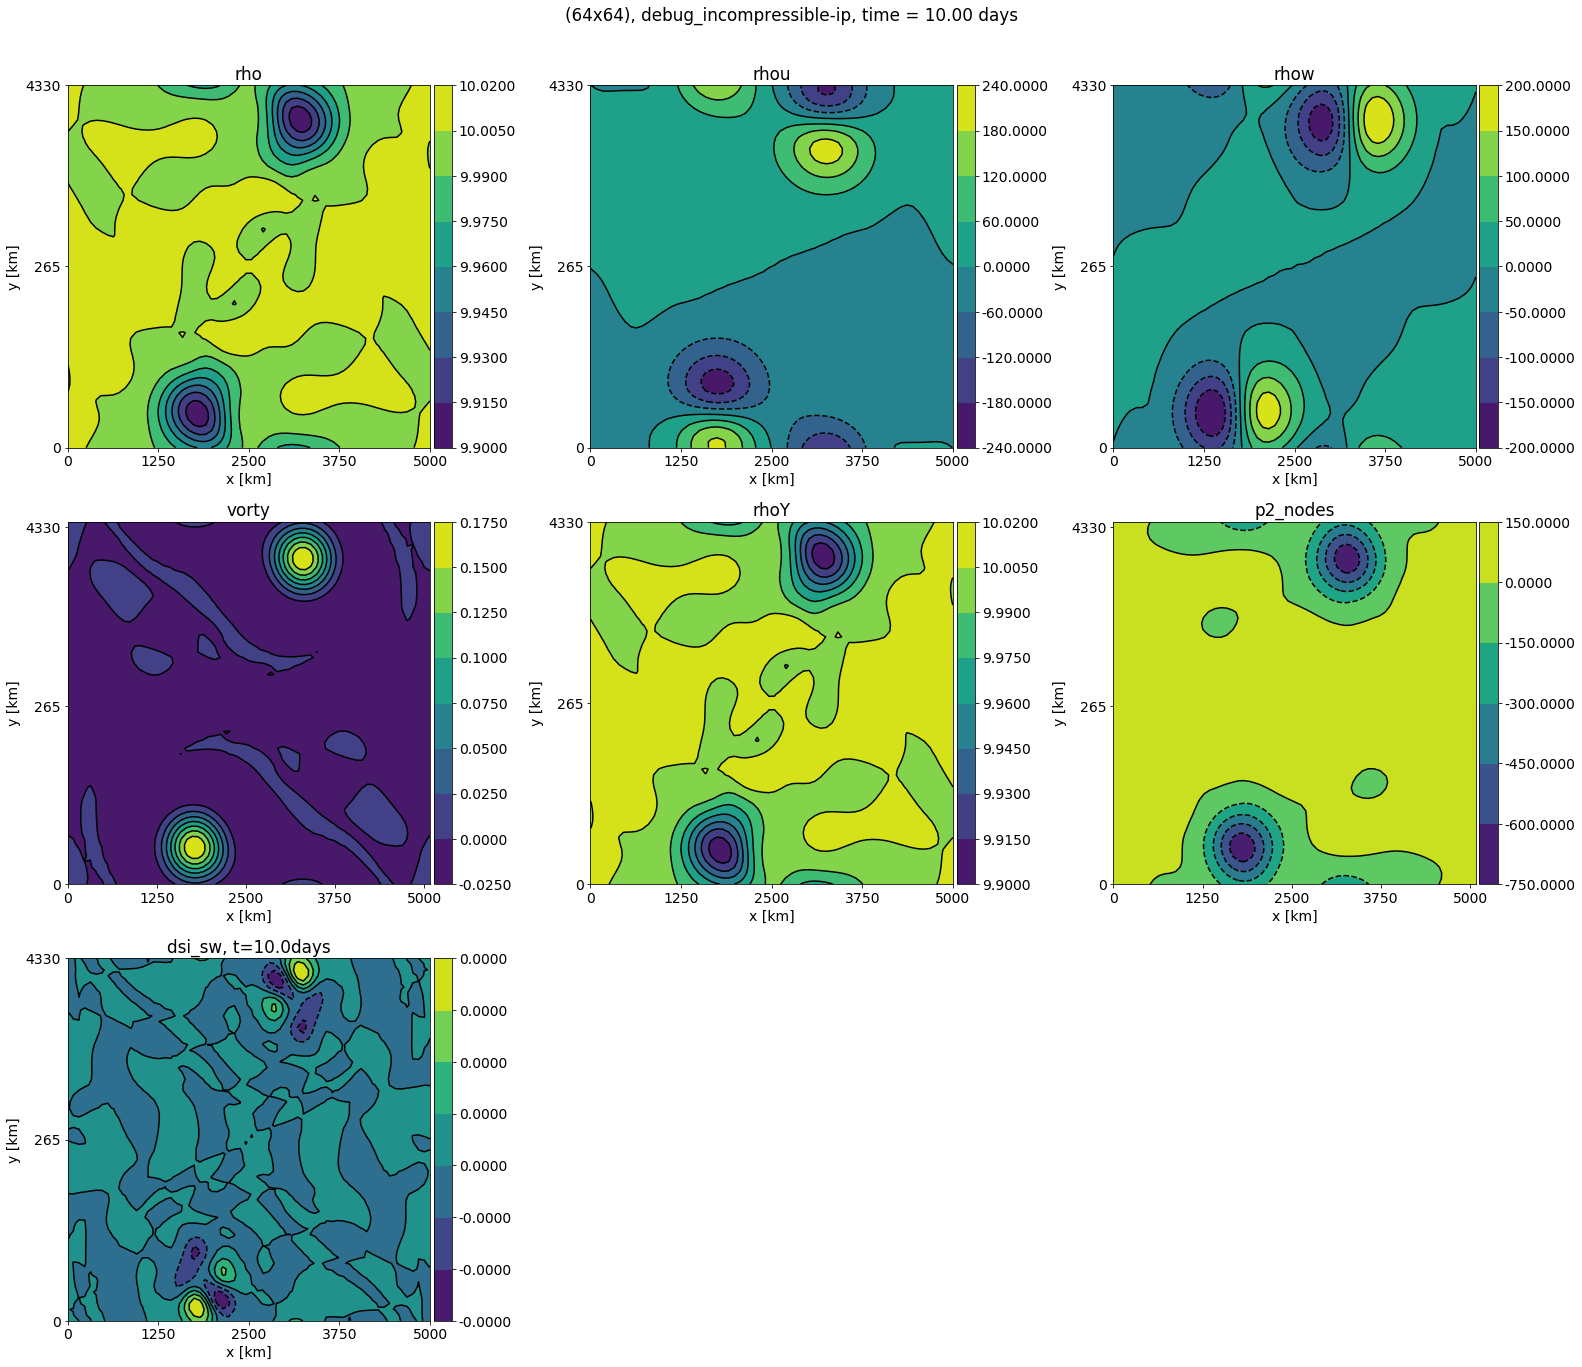

In [174]:
N = 1
sfx = 'debug_incompressible-ip'
# sfx = 'debug_semigeo'
# sfx = 'debug_quasigeo'
# sfx = 'debug_psinc'

fn_pickle = tc.get_filename(N,sfx,format='dat')
path_pickle = tc.get_path(fn_pickle)
fn = tc.get_filename(N,sfx)
path = tc.get_path(fn)

attributes = ['rho','rhou','rhow','vorty','rhoY','p2_nodes']
t_lbl = 'TIME'
slc = 0

times = np.array([72.0]) * 10.0
times = np.arange(0,720.0+72.0,72.0)
# times = np.arange(0,216.0+72.0,72.0)
# times = np.arange(0.0,30.0)
# times = np.arange(0,360.0+72.0,72.0)

tag = tags[9]

# load pickled data
file = open(path_pickle,'rb')
ud = pickle.load(file)
elem = pickle.load(file)
node = pickle.load(file)
file.close()

# ud.d_ref = ud.h_ref

class oo(object): pass
data = oo()

g = ud.g0 # consider putting this into ud

debug = True
if debug == True: arr_lst = []
time_series = np.zeros((times.shape[0],len(attributes)+1,2), dtype='object')
# time_series = np.zeros((times.shape[0],2), dtype='object')

for tt,time in enumerate(times):
    tag = 'ic' if tt == 0 else tags[9]
    for atr_idx, attribute in enumerate(attributes):
        arr = tc.get_arr(path, time, N, attribute, label_type=t_lbl, tag=tag, inner=True, avg=False)[0][:,slc,:]
        arr = arr.T
        
        setattr(data,attribute,arr)
        arr = [arr, attribute]

        time_series[tt,atr_idx] = arr
        
    # Calculate DSI_SW
    dsi_sw = dsi.get_DSI_SW(data, g, ud, elem)
    dsi_sw = [dsi_sw,'dsi_sw, t=%.1fdays' %(tt)]
    
    time_series[tt,atr_idx+1] = dsi_sw
#     time_series[tt] = dsi_sw

if debug == True:
    idx = 10
    fs = (22,5.5)
    fs = (22,20)
    # fs = (6,6)
    ncolslen = int((len(attributes))/2) if len(attributes) > 1 else 1
    ncolslen = 3
    pl = pt.plotter(time_series[idx],ncols=ncolslen,figsize=fs,sharey=False)

    x_axs = [0,1250,2500,3750,5000]
    y_axs = [0,265,4330]
    x_loc = np.linspace(0,Nx-1,5)
    y_loc = np.linspace(0,Nz-1,3)
    x_label = r'x [km]'
    y_label = r'y [km]'
    st = 'SWE shear flow (%ix%i), $\Delta t = 12s$. Potential vortcity in the (x-z) plane.' %(Nx,Nz)
    st = '(%ix%i), %s, time = %.2f days' %(Nx,Nz, sfx, times[idx]*1200/(3600*24))

    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
    _ = pl.plot(aspect='equal',method='contour',suptitle=st)
#     pl.save_fig('ivg_%idays' %(times[idx]*1200/(3600*24)))